In [16]:
import os
PATH = '/home/johnny/git/aurelius'
os.chdir(PATH)

from app.model import AutoEncoder
import torch

In [17]:
TIMESTEPS = 100
ENCODING_DIM = 7
HIDDEN_DIM = 64
device = torch.device('cpu')

model = AutoEncoder(TIMESTEPS, ENCODING_DIM, [HIDDEN_DIM])
model.to(device)
model.load_state_dict(torch.load('./checkpoint.pt'))
model.eval()


AutoEncoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): LSTM(100, 64, batch_first=True)
      (1): LSTM(64, 7, batch_first=True)
    )
    (h_activ): Sigmoid()
    (out_activ): Tanh()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): LSTM(7, 64, batch_first=True)
      (1): LSTM(64, 64, batch_first=True)
    )
    (h_activ): Sigmoid()
  )
)

In [42]:
from app.utils import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
def compare(freq, phase, title=''):
    sine = [(np.sin(freq * j + phase) + 1)*0.5 for j in range(TIMESTEPS)]
    tensor_sine = torch.tensor(sine).unsqueeze(0).float()
    out = model(tensor_sine).squeeze().data
    plt.plot(sine, label='original signal')
    plt.plot(out, label='model output')
    plt.legend()
    plt.title(title)
    plt.show()

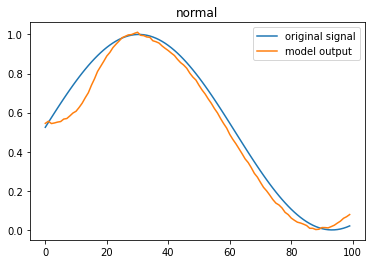

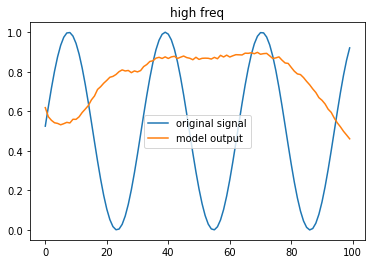

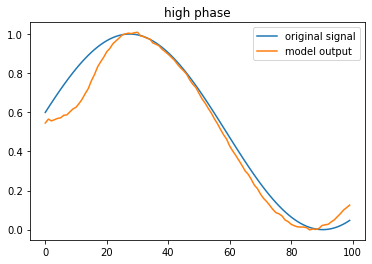

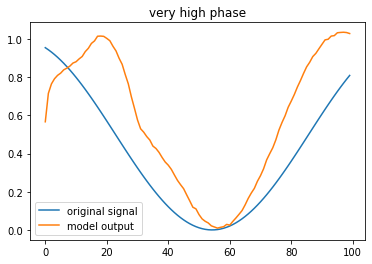

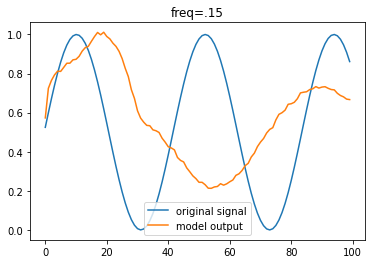

In [46]:
# freq was trained between 0 and .1
# phase was trained between 0 and .1
compare(freq = 0.05, phase=0.05, title='normal')
compare(freq = 0.2, phase=0.05, title='high freq')
compare(freq = 0.05, phase=0.2, title='high phase')
compare(freq = 0.05, phase=2, title='very high phase')
compare(freq = 0.15, phase=0.05, title='freq=.15')